In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "mmpot"))

import seaborn as sns
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy.io import loadmat
import time
from tqdm import tqdm
import ot
import copy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### a) Helper function

In [2]:
def measure_sparsity(solution_matrix, threshold=1e-10):
    """
    Hàm này đo lường sparsity của một ma trận, xem xét các phần tử có giá trị tuyệt đối
    nhỏ hơn ngưỡng đã chỉ định là bằng 0.

    Sparsity được định nghĩa là tỷ lệ các phần tử được xem là bằng 0 trong ma trận.

    Tham số:
    solution_matrix (np.ndarray): Ma trận cần đo lường sparsity.
    threshold (float): Ngưỡng dưới đó các phần tử được coi là bằng 0 (mặc định là 1e-10).

    Trả về:
    float: Độ sparsity của ma trận, dưới dạng giá trị từ 0 đến 1.
    """
    # Đếm số lượng phần tử được coi là bằng 0 (nhỏ hơn ngưỡng)
    zero_elements = np.sum(np.abs(solution_matrix) < threshold)

    # Tính tổng số phần tử trong ma trận
    total_elements = solution_matrix.size

    # Tính độ sparsity dưới dạng tỷ lệ của các phần tử được coi là bằng 0
    sparsity = zero_elements / total_elements

    return sparsity

In [3]:
# Hàm giải bài toán Optimal Transport (OT) không có regularizer
def sinkhornfix(a, b, C, epsilon, max_iter=1000, tol=1e-9, verbose=False):
    n, m = C.shape
    K = np.exp(-C / epsilon)
    
    u = np.ones(n)
    v = np.ones(m)
    
    for i in range(max_iter):
        u_prev, v_prev = u.copy(), v.copy()
        
        # Update u and v using the Sinkhorn iteration
        u = a / (np.dot(K, v) + 1e-12)  # Adding a small constant to avoid division by zero
        v = b / (np.dot(K.T, u) + 1e-12)

        if verbose:
            print("Iteration:", i)
            print("u:", u)
            print("v:", v)
        
        # Check for convergence
        if np.linalg.norm(u - u_prev, 1) < tol and np.linalg.norm(v - v_prev, 1) < tol:
            break
    
    P = np.outer(u, v) * K
    return P

def sinkhorn_log_domain(a, b, C, epsilon, max_iter=1000, tol=1e-9, verbose=False):
    n, m = C.shape
    
    # Instead of using K directly, work with its logarithm
    log_K = -C / epsilon
    
    # Initialize log_u and log_v
    log_u = np.zeros(n)
    log_v = np.zeros(m)
    
    for i in range(max_iter):
        log_u_prev, log_v_prev = log_u.copy(), log_v.copy()
        
        # Update log_u and log_v using log-domain Sinkhorn iterations
        log_u = np.log(a) - np.log(np.exp(log_K + log_v).sum(axis=1) + 1e-12)
        log_v = np.log(b) - np.log(np.exp(log_K.T + log_u).sum(axis=1) + 1e-12)

        if verbose:
            print("Iteration:", i)
            print("log_u:", log_u)
            print("log_v:", log_v)
        
        # Check for convergence
        if np.linalg.norm(log_u - log_u_prev, 1) < tol and np.linalg.norm(log_v - log_v_prev, 1) < tol:
            break
    
    # Compute the transport plan in the original space
    u = np.exp(log_u)
    v = np.exp(log_v)
    P = np.outer(u, v) * np.exp(log_K)
    
    return P

def solve_ot(source_hist, target_hist, C):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) == source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) == target_hist,  # Tổng theo cột bằng phân phối đích
    ]

    # Định nghĩa hàm mục tiêu chỉ với cost matrix C mà không có regularizer
    objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value

def solve_pot_entropic_kl_regularization(source_hist, target_hist, C, s, epsilon):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) <= source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) <= target_hist,  # Tổng theo cột bằng phân phối đích
        cp.sum(X) == s
    ]

    # Define the cost term: sum(C * X)
    cost_term = cp.sum(cp.multiply(C, X))

    # Define the entropic regularization term: sum(X_ij * log(X_ij) - X_ij)
    # Using cp.kl_div(X_ij, 1) which computes X_ij * log(X_ij) - X_ij for each element
    entropy_term = cp.sum(cp.kl_div(X, np.ones((n, m))))

    # Define the objective function: cost term + epsilon * entropy term
    objective = cp.Minimize(cost_term + epsilon * entropy_term)


    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, max_iters=5000)

    return X.value

# Hàm giải bài toán Optimal Transport (OT) có regularizer
def solve_ot_quadratic_regularization(source_hist, target_hist, C, epsilon):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) == source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) == target_hist,  # Tổng theo cột bằng phân phối đích
    ]

    # Định nghĩa hàm mục tiêu chỉ với cost matrix C mà không có regularizer
    objective = cp.Minimize(cp.sum(cp.multiply(C, X))+(epsilon / 2) * cp.norm(X, "fro") ** 2)

    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value

# Hàm giải bài toán Optimal Transport (OT) không có regularizer
def solve_pot_entropic_regularization(source_hist, target_hist, C, s, epsilon):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) <= source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) <= target_hist,  # Tổng theo cột bằng phân phối đích
        cp.sum(X) == s
    ]

    # Định nghĩa hàm mục tiêu chỉ với cost matrix C mà không có regularizer
    def entropy(X):
        tau=1e-10
        return cp.sum(cp.entr(X + tau))  # Use the entr function which is DCP-compliant

    # Define the objective function
    objective = cp.Minimize(cp.sum(cp.multiply(C, X)) - (epsilon/2) * entropy(X))


    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(solver=cp.CLARABEL)
    except:
        return np.nan

    return X.value

def solve_ot_entropic_regularization(source_hist, target_hist, C, epsilon):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) == source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) == target_hist,  # Tổng theo cột bằng phân phối đích
    ]

    # Định nghĩa hàm mục tiêu chỉ với cost matrix C mà không có regularizer
    def entropy(X):
        tau=1e-10
        return cp.sum(cp.entr(X + tau))  # Use the entr function which is DCP-compliant

    # Define the objective function
    objective = cp.Minimize(cp.sum(cp.multiply(C, X)) - (epsilon/2) * entropy(X))

    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    return X.value

# Hàm giải POT với quadratic regularizer
def solve_pot_quadratic_regularization(source_hist, target_hist, C, s, epsilon):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) <= source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) <= target_hist,  # Tổng theo cột bằng phân phối đích
        cp.sum(X) == s
    ]

    # Định nghĩa hàm mục tiêu chỉ với cost matrix C mà không có regularizer
    objective = cp.Minimize(cp.sum(cp.multiply(C, X))+(epsilon / 2) * cp.norm(X, "fro") ** 2)


    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value

def solve_pot_linear_regularization(source_hist, target_hist, C, s, epsilon):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) <= source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) <= target_hist,  # Tổng theo cột bằng phân phối đích
        cp.sum(X) == s
    ]

    # Định nghĩa hàm mục tiêu chỉ với cost matrix C mà không có regularizer
    objective = cp.Minimize(cp.sum(cp.multiply(C, X))+(epsilon / 2) * cp.norm(X, "fro"))


    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value 

def solve_pot(source_hist, target_hist, C, s):
    n = source_hist.shape[0]
    m = target_hist.shape[0]

    # Khai báo biến
    X = cp.Variable((n, m), nonneg=True)

    # Định nghĩa các ràng buộc cho bài toán OT
    constraints = [
        cp.sum(X, axis=1) <= source_hist,  # Tổng theo hàng bằng phân phối nguồn
        cp.sum(X, axis=0) <= target_hist,  # Tổng theo cột bằng phân phối đích
        cp.sum(X) == s
    ]

    # Định nghĩa hàm mục tiêu chỉ với cost matrix C mà không có regularizer
    objective = cp.Minimize(cp.sum(cp.multiply(C, X)))


    # Định nghĩa và giải bài toán
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return X.value

def round_heatmap(method_matrices, epsilon, threshold=1e-10):
    """
    Plots heatmaps for the provided method matrices (solutions) and includes epsilon in the plot title.
    
    :param threshold: The threshold value to discretize the solution matrices.
    :param epsilon: The epsilon value to display in the plot title.
    :param method_matrices: A dictionary where keys are method names and values are the corresponding solution matrices.
    """
    # Discretize all input matrices (round them based on threshold)
    rounded_matrices = {method: np.where(np.abs(matrix) < threshold, 0, 1) for method, matrix in method_matrices.items()}
    
    num_matrices = len(rounded_matrices)
    max_columns = 3  # Maximum 3 matrices per row
    num_rows = (num_matrices + max_columns - 1) // max_columns  # Calculate the number of rows needed

    plt.rcParams['font.family'] = 'serif'
    fig, axes = plt.subplots(num_rows, max_columns, figsize=(6 * max_columns, 6 * num_rows))
    axes = axes.flatten()  # Flatten the axes for easy iteration

    for idx, (method_name, rounded_matrix) in enumerate(rounded_matrices.items()):
        ax = axes[idx]

        # Draw the heatmap for each method
        sns.heatmap(rounded_matrix, cmap=sns.color_palette(["white", "red"], as_cmap=True), ax=ax, cbar=False)
        
        # Set title and format the plot
        ax.set_title(f"Transport Plan {method_name}\nEpsilon: {epsilon}, Sparsity: {np.round(measure_sparsity(rounded_matrix), 4)}", fontsize=16)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        
        # Add a box around the heatmap
        for _, spine in ax.spines.items():
            spine.set_visible(True)
            spine.set_linewidth(1.5)
            spine.set_color('black')

    # If there are unused axes, hide them
    for idx in range(len(rounded_matrices), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


#### Converting color spaces

In [4]:
def rgb2luv(I):
    """
    Convert an image from rgb to luv color space, where
    l = r + g + b
    u = r / l
    v = g / l.
    This reduces the dimensionality of the color space from 3 to 2.
    """
    J = np.zeros(I.shape)
    J[:, :, 0] = np.sum(I, axis=2)
    J[:, :, 1] = I[:, :, 0] / (1e-14 + J[:, :, 0])
    J[:, :, 2] = I[:, :, 1] / (1e-14 + J[:, :, 0])
    return J


def luv2rgb(J):
    """
    Convert an image from luv to rgb color space.
    """
    I = np.zeros(J.shape)
    I[:, :, 0] = (J[:, :, 0] + 1e-14) * J[:, :, 1]
    I[:, :, 1] = (J[:, :, 0] + 1e-14) * J[:, :, 2]
    I[:, :, 2] = (J[:, :, 0] + 1e-14) * (1.0 - J[:, :, 1] - J[:, :, 2])
    return I

#### Apply color transport

In [5]:
def apply_transport(T, Y, luvY=None):
    """
    Áp dụng ma trận vận chuyển T lên hình ảnh Y.
    Args:
        T: Ma trận vận chuyển có kích thước (B**2, B**2)
        Y: Hình ảnh gốc ở không gian màu RGB
        luvY: Hình ảnh gốc ở không gian màu Luv (nếu có)
    """
    # Nếu không có luvY, chuyển đổi từ RGB sang Luv
    if luvY is None:
        luvY = rgb2luv(Y)

    # Tính toán B từ kích thước của ma trận vận chuyển T
    B = int(np.sqrt(np.shape(T)[0]))

    # Khởi tạo mảng om để lưu trữ các tọa độ màu mới
    om = np.zeros((B, B, 3))

    # Vòng lặp qua tất cả các cặp (i, j) trong không gian màu
    for i in range(B):
        for j in range(B - i):
            # Biến để lưu tổng của các giá trị trong T
            som = 1e-14

            # Vòng lặp qua tất cả các cặp (k, l) để tính toán các tọa độ mới
            for k in range(B):
                for l in range(B - k):
                    # Cập nhật tọa độ L (Y channel)
                    om[i, j, 0] += k * T[B * i + j, B * k + l]
                    # Cập nhật tọa độ U (U channel)
                    om[i, j, 1] += l * T[B * i + j, B * k + l]
                    # Cập nhật tọa độ V (V channel)
                    om[i, j, 2] += (B - 1 - k - l) * T[B * i + j, B * k + l]
                    # Cộng dồn vào tổng som
                    som += T[B * i + j, B * k + l]

            # Chuẩn hóa các tọa độ bằng cách chia cho tổng som
            om[i, j, 0] /= som
            om[i, j, 1] /= som
            om[i, j, 2] /= som

    # Khởi tạo mảng cY và nY để lưu trữ hình ảnh gốc và hình ảnh mới sau khi áp dụng phép biến đổi
    cY = np.zeros(Y.shape)
    nY = np.zeros(Y.shape)

    # Vòng lặp qua tất cả các pixel trong hình ảnh
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            # Lấy giá trị U và V từ không gian Luv
            r = luvY[i, j, 1]
            g = luvY[i, j, 2]
            # Tính toán giá trị B channel từ U và V
            b = 1 - r - g

            # Chuyển đổi U và V về các chỉ số tương ứng trong ma trận om
            k = int(np.clip(B * r, 0.0, B - 1.0))
            l = int(np.clip(B * g, 0.0, B - 1.0))

            # Cập nhật giá trị màu cho hình ảnh gốc cY
            cY[i, j, :] = (luvY[i, j, 0] + 1e-14) * np.array([r, g, b])
            # Cập nhật giá trị màu cho hình ảnh sau biến đổi nY
            nY[i, j, :] = (luvY[i, j, 0] + 1e-14) * om[k, l, :] / (B - 1.0)

    # Trả về hai hình ảnh: cY (gốc) và nY (sau biến đổi)
    return cY, nY

### b) Set up cho color transfer

#### Quy định các đường dẫn cho hình ảnh

In [6]:
data_path = os.path.join(os.path.join(os.getcwd(), "color_transfer_data"))
source_path = os.path.join(data_path, "gatech.jpeg")
target_path = os.path.join(data_path, "fall leaves.jpg")
output_path = os.path.join(data_path, "gatech_to_leaves.mat")

B = 32

#### Tải hình ảnh, chuyển đổi các hình từ color space RGB sang LUV

Text(0.5, 1.0, 'Source Image (RGB)')

(-0.5, 1079.5, 1079.5, -0.5)

Text(0.5, 1.0, 'Target Image (RGB)')

(-0.5, 465.5, 465.5, -0.5)

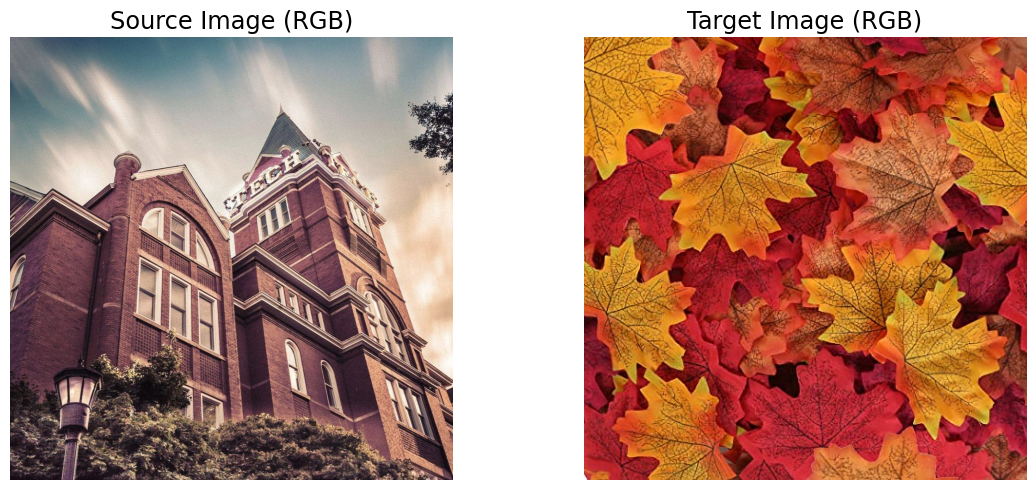

In [7]:
# Đọc hình ảnh nguồn (source image) từ đường dẫn và chuyển đổi sang không gian RGB
source_rgb = img.imread(source_path)  # Đọc hình ảnh từ file
source_rgb = source_rgb / 255  # Chuẩn hóa giá trị pixel từ [0, 255] về [0, 1]
source_luv = rgb2luv(source_rgb)  # Chuyển đổi từ không gian RGB sang Luv

# Đọc hình ảnh mục tiêu (target image) từ đường dẫn và chuyển đổi sang không gian RGB
target_rgb = img.imread(target_path)  # Đọc hình ảnh từ file
target_rgb = target_rgb / 255  # Chuẩn hóa giá trị pixel từ [0, 255] về [0, 1]
target_luv = rgb2luv(target_rgb)  # Chuyển đổi từ không gian RGB sang Luv

# Tạo một cửa sổ gồm 2x2 subplot để hiển thị hình ảnh
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Hàng đầu tiên: Hiển thị hình ảnh trong không gian RGB
axes[0].imshow(source_rgb)  # Hiển thị hình ảnh nguồn (RGB)
axes[0].set_title("Source Image (RGB)", size="xx-large")
axes[0].axis("off")

axes[ 1].imshow(target_rgb)  # Hiển thị hình ảnh mục tiêu (RGB)
axes[ 1].set_title("Target Image (RGB)", size="xx-large")
axes[ 1].axis("off")

# Hàng thứ hai: Hiển thị hình ảnh trong không gian Luv
# axes[1, 0].imshow(source_luv)  # Hiển thị hình ảnh nguồn (Luv)
# axes[1, 0].set_title("Source Image (Luv)", size="xx-large") 
# axes[1, 0].axis("off")

# axes[1, 1].imshow(target_luv)  # Hiển thị hình ảnh mục tiêu (Luv)
# axes[1, 1].set_title("Target Image (Luv)", size="xx-large")
# axes[1, 1].axis("off")


plt.tight_layout()
plt.show()

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

Text(0, 0.5, 'RED Channel')

Text(0, 0.5, '')

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

Text(0, 0.5, 'GREEN Channel')

Text(0, 0.5, '')

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

Text(0, 0.5, 'BLUE Channel')

Text(0, 0.5, '')

Text(0.5, 1.0, 'Source Image RGB Histograms')

Text(0.5, 1.0, 'Target Image RGB Histograms')

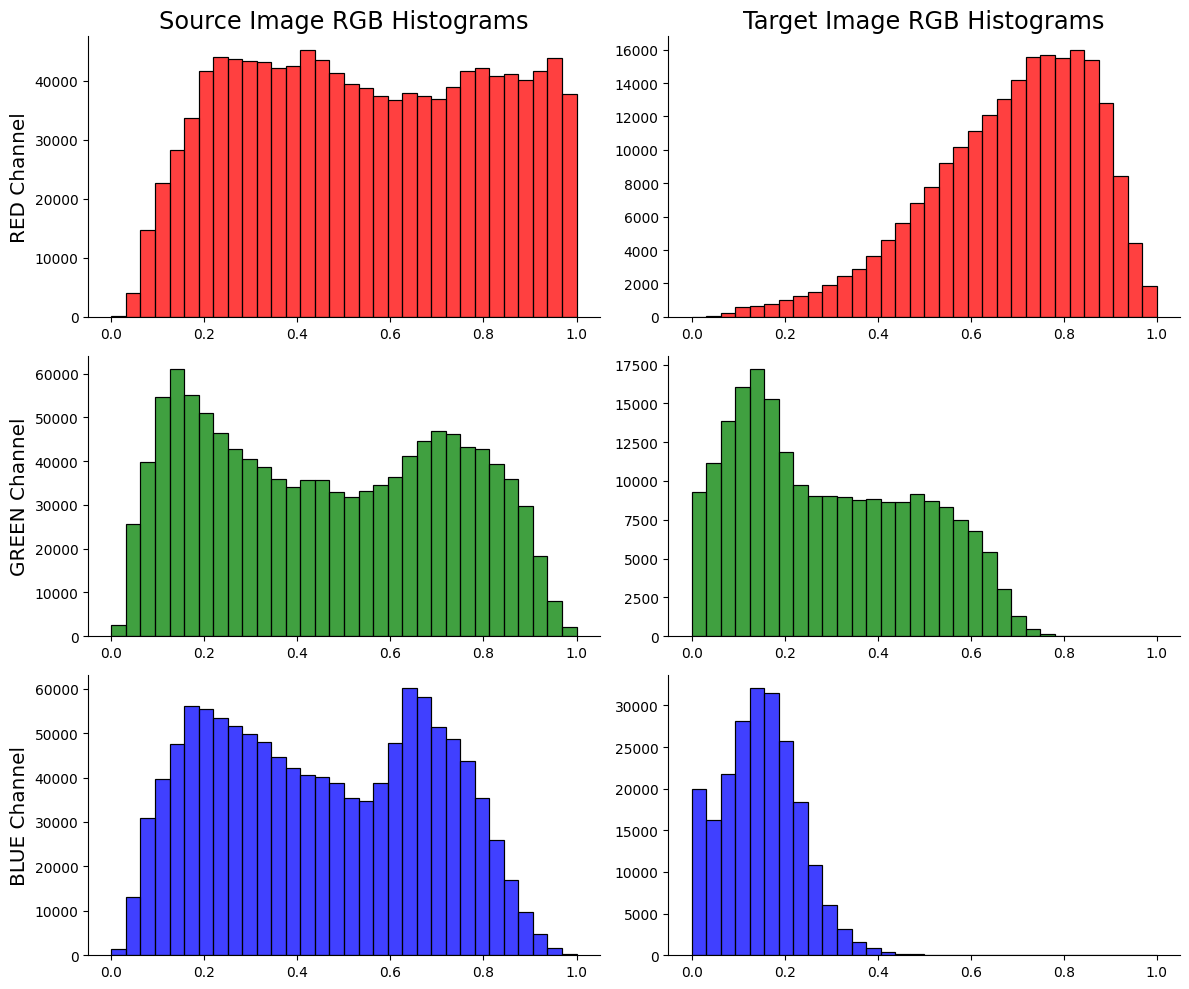

In [8]:
# Visualize RGB channels for source and target images
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
colors = ["red", "green", "blue"]
for i, color in enumerate(colors):
    sns.histplot(
        source_rgb[:, :, i].flatten(),
        color=color,
        bins=32,
        ax=axes[i, 0],
        binrange=(0, 1),
    )
    sns.histplot(
        target_rgb[:, :, i].flatten(),
        color=color,
        bins=32,
        ax=axes[i, 1],
        binrange=(0, 1),
    )
    axes[i, 0].set_ylabel(f"{color.upper()} Channel", size="x-large")
    axes[i, 1].set_ylabel("")
    sns.despine()

axes[0, 0].set_title("Source Image RGB Histograms", size="xx-large")
axes[0, 1].set_title("Target Image RGB Histograms", size="xx-large")
plt.tight_layout()
plt.show()

#### Tạo các histogram màu, đồng thời làm phẳng và chuẩn hóa

<BarContainer object of 1024 artists>

Text(0.5, 1.0, 'Source Histogram')

Text(0.5, 0, 'Bin Index')

Text(0, 0.5, 'Frequency')

<BarContainer object of 1024 artists>

Text(0.5, 1.0, 'Target Histogram')

Text(0.5, 0, 'Bin Index')

Text(0, 0.5, 'Frequency')

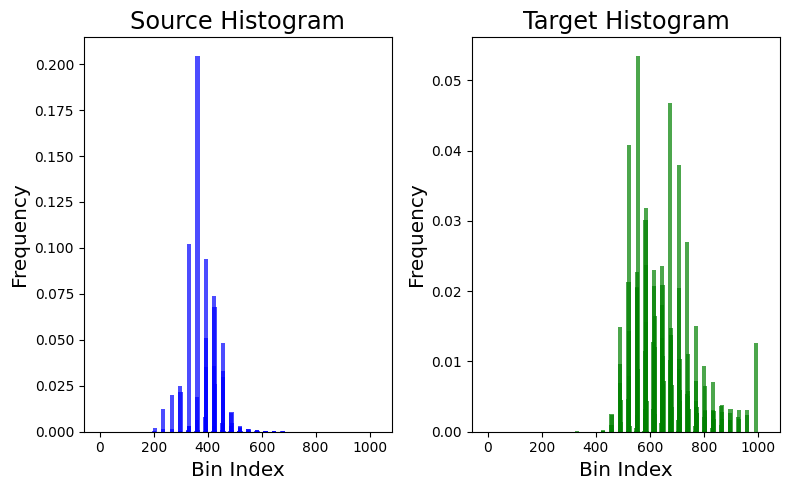

In [9]:
# Tạo histogram màu 2D cho source image
source_hist, _, _ = np.histogram2d(
    x=source_luv.reshape((-1, 3))[:, 1].flatten(),  # Trích xuất kênh U từ không gian màu Luv
    y=source_luv.reshape((-1, 3))[:, 2].flatten(),  # Trích xuất kênh V từ không gian màu Luv
    bins=B,
    range=[[0, 1], [0, 1]],
)

# Tạo histogram màu 2D cho target image
target_hist, _, _ = np.histogram2d(
    x=target_luv.reshape((-1, 3))[:, 1].flatten(),  # Trích xuất kênh U từ không gian màu Luv 
    y=target_luv.reshape((-1, 3))[:, 2].flatten(),  # Trích xuất kênh V từ không gian màu Luv
    bins=B,
    range=[[0, 1], [0, 1]],
)

# Smooth các histogram để đảm bảo không có bin nào trống
eps = 1e-7  # Một giá trị epsilon nhỏ để đảm bảo các bin không bằng 0
source_hist += eps  
target_hist += eps  

# Chuẩn hóa các histogram
normalize_hist = True
if normalize_hist:
    source_hist /= (source_hist.sum())  
    target_hist /= (target_hist.sum())  

# Làm phẳng histogram của source image
source_hist = source_hist.flatten()  # Chuyển histogram thành mảng 1D
# Kiểm tra nếu histogram vẫn không phải là mảng 1D sau khi làm phẳng
if len(source_hist.shape) != 1:
    source_hist = source_hist[0]  # Nếu không phải mảng 1D, lấy phần tử đầu tiên

# Làm phẳng histogram của target image
target_hist = target_hist.flatten()  # Chuyển histogram thành mảng 1D
# Kiểm tra nếu histogram vẫn không phải là mảng 1D sau khi làm phẳng
if len(target_hist.shape) != 1:
    target_hist = target_hist[0]  # Nếu không phải mảng 1D, lấy phần tử đầu tiên


num_bins = len(source_hist)
fig, axes = plt.subplots(1, 2, figsize=(8, 5))  # 2 hàng, 1 cột

# Vẽ histogram của hình ảnh nguồn
axes[0].bar(
    range(num_bins), source_hist, color="blue", alpha=0.7, width=15
) 
axes[0].set_title("Source Histogram", size="xx-large")  # Đặt tiêu đề cho biểu đồ
axes[0].set_xlabel("Bin Index", size="x-large")  # Đặt nhãn trục x
axes[0].set_ylabel("Frequency", size="x-large")  # Đặt nhãn trục y

# Vẽ histogram của hình ảnh mục tiêu
axes[1].bar(
    range(num_bins), target_hist, color="green", alpha=0.7, width=15
    )
axes[1].set_title("Target Histogram", size="xx-large")  # Đặt tiêu đề cho biểu đồ
axes[1].set_xlabel("Bin Index", size="x-large")  # Đặt nhãn trục x
axes[1].set_ylabel("Frequency", size="x-large")  # Đặt nhãn trục y

plt.tight_layout()
plt.show()

#### Tạo cost matrix

In [10]:
# Khởi tạo ma trận C với kích thước B*B x B*B, các phần tử ban đầu bằng 0
C = np.zeros((B * B, B * B), dtype=float)

# Vòng lặp qua các cặp (i, j) và (k, l) để tính toán khoảng cách bình phương giữa chúng
for i in range(B):
    for j in range(B):
        for k in range(B):
            for l in range(B):
                # Tính chỉ số hàng và cột tương ứng trong ma trận C
                row = i * B + j  # Chỉ số hàng tương ứng với cặp (i, j)
                col = k * B + l  # Chỉ số cột tương ứng với cặp (k, l)

                # Tính toán khoảng cách Euclidean bình phương giữa hai cặp (i, j) và (k, l)
                C[row, col] = (i - k) ** 2 + (j - l) ** 2

# Chuẩn hóa ma trận C bằng cách chia cho giá trị lớn nhất trong ma trận
C = C / np.max(C)


### c) Thực hiện color transfer trên nhiều OT methods trên nhiều epsilon

In [11]:
rerun_cf = True

# Define lambda and transport mass
for lambda_param in [0.6, 0.7, 0.9, 0.95][:2]:
    s = lambda_param * min(source_hist.sum(), target_hist.sum())

    epsilonsCF = [2**(-i/2) for i in [-i for i in range(1,41)]]

    # Run the other OT methods
    print("Run the other OT methods")
    if rerun_cf:
        sparsityCF_QPOT = []
        runtimesCF_QPOT = []
        ResultCF_QPOT = []

        sparsityCF_EPOT = []
        runtimesCF_EPOT = []
        ResultCF_EPOT = []

        # sparsityCF_KLPOT = []
        # runtimesCF_KLPOT = []
        # ResultCF_KLPOT = []

        for i in tqdm(range(len(epsilonsCF))):
            epsilon=epsilonsCF[i]
            # Run QPOT
            start_time = time.time()
            T_qpot = solve_pot_quadratic_regularization(source_hist, target_hist, C, s, epsilon)
            runtime_QPOT = time.time() - start_time

            # Run Entropic POT
            start_time = time.time()
            T_epot = solve_pot_entropic_regularization(source_hist, target_hist, C, s, epsilon)
            runtime_EPOT = time.time() - start_time

            # # Run Entropic POT with KL divergence
            # start_time = time.time()
            # T_klpot = solve_pot_entropic_kl_regularization(source_hist, target_hist, C, s, epsilon)
            # runtime_KLPOT = time.time() - start_time

            # Append the result
            sparsityCF_QPOT.append(measure_sparsity(T_qpot))
            runtimesCF_QPOT.append(runtime_QPOT)
            ResultCF_QPOT.append(T_qpot)
            
            # Append the result
            if np.isnan(T_epot).any():
                sparsityCF_EPOT.append(np.nan)
            else:
                sparsityCF_EPOT.append(measure_sparsity(T_epot))
            runtimesCF_EPOT.append(runtime_EPOT)
            ResultCF_EPOT.append(T_epot)

            # sparsityCF_KLPOT.append(measure_sparsity(T_klpot))
            # runtimesCF_KLPOT.append(runtime_KLPOT)
            # ResultCF_KLPOT.append(T_klpot)

        # Save the final results
        target_folder = 'color_transfer_result_lambda_' + str(lambda_param)
        if os.path.exists(target_folder) == False:
            os.mkdir(target_folder)
        np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity QPOTCF.npy', sparsityCF_QPOT)
        np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes QPOTCF.npy', runtimesCF_QPOT)
        np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result QPOTCF.npy', ResultCF_QPOT)
        
        np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity EPOTCF.npy', sparsityCF_EPOT)
        np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes EPOTCF.npy', runtimesCF_EPOT)
        np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result EPOTCF.npy', ResultCF_EPOT)
        
        # np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity KLPOTCF.npy', sparsityCF_KLPOT)
        # np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes KLPOTCF.npy', runtimesCF_KLPOT)
        # np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result KLPOTCF.npy', ResultCF_KLPOT)
    else:
        sparsityCF_QPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity QPOTCF.npy')
        runtimesCF_QPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes QPOTCF.npy')
        ResultCF_QPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result QPOTCF.npy')

        sparsityCF_EPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity EPOTCF.npy')
        runtimesCF_EPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes EPOTCF.npy')
        ResultCF_EPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result EPOTCF.npy')

        # sparsityCF_KLPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity KLPOTCF.npy')
        # runtimesCF_KLPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes KLPOTCF.npy')
        # ResultCF_KLPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result KLPOTCF.npy')

Run the other OT methods


  0%|          | 0/40 [00:00<?, ?it/s]h:\Materials\AI Courses\.venv\lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 40/40 [4:02:15<00:00, 363.39s/it]  


Run the other OT methods


100%|██████████| 40/40 [3:39:22<00:00, 329.07s/it]  


In [12]:
# rerun_cf = True

# # Define lambda and transport mass
# lambda_param=0.7
# s = lambda_param * min(source_hist.sum(), target_hist.sum())

# # Run first round of OT and POT
# print("Run first round of OT and POT")
# start_time = time.time()
# T_ot = solve_ot(source_hist, target_hist, C)
# runtime_OT = time.time() - start_time
# start_time = time.time()
# T_pot = solve_pot(source_hist, target_hist, C, s)
# runtime_POT = time.time() - start_time
# sparsityCF_OT = measure_sparsity(T_ot)
# sparsityCF_POT = measure_sparsity(T_pot)

# epsilonsCF = [2**(-i/2) for i in [-i for i in range(1,41)]]

# # Run the other OT methods
# print("Run the other OT methods")
# if rerun_cf:
#     sparsityCF_QPOT = []
#     runtimesCF_QPOT = []
#     ResultCF_QPOT = []

#     sparsityCF_QOT = []
#     runtimesCF_QOT = []
#     ResultCF_QOT = []

#     sparsityCF_EOT = []
#     runtimesCF_EOT = []
#     ResultCF_EOT = []

#     sparsityCF_EOTL = []
#     runtimesCF_EOTL = []
#     ResultCF_EOTL = []

#     sparsityCF_LEOT = []
#     runtimesCF_LEOT = []
#     ResultCF_LEOT = []

#     sparsityCF_EPOT = []
#     runtimesCF_EPOT = []
#     ResultCF_EPOT = []

#     sparsityCF_KLPOT = []
#     runtimesCF_KLPOT = []
#     ResultCF_KLPOT = []

#     for i in tqdm(range(len(epsilonsCF))):
#         epsilon=epsilonsCF[i]
#         # Run QPOT
#         start_time = time.time()
#         T_qpot = solve_pot_quadratic_regularization(source_hist, target_hist, C, s, epsilon)
#         runtime_QPOT = time.time() - start_time

#         # Run QOT
#         start_time = time.time()
#         T_qot = solve_ot_quadratic_regularization(source_hist, target_hist, C, epsilon)
#         runtime_QOT = time.time() - start_time

#         # Run Sinkhorn with hand-written Sinkhorn
#         start_time = time.time()
#         T_eot = sinkhornfix(source_hist, target_hist, C, epsilon)
#         runtime_EOT = time.time() - start_time

#         # Run Sinkhorn with hand-written log-domain Sinkhorn
#         start_time = time.time()
#         T_log_eot = sinkhorn_log_domain(source_hist, target_hist, C, epsilon, verbose=False)
#         runtime_LEOT = time.time() - start_time

#         # Run Sinkhorn from POT Sinkhorn
#         start_time = time.time()
#         T_eotl = ot.sinkhorn(source_hist, target_hist, C, epsilon)
#         runtime_EOTL = time.time() - start_time

#         # Run Entropic POT
#         start_time = time.time()
#         T_epot = solve_pot_entropic_regularization(source_hist, target_hist, C, s, epsilon)
#         runtime_EPOT = time.time() - start_time

#         # Run Entropic POT with KL divergence
#         start_time = time.time()
#         T_klpot = solve_pot_entropic_kl_regularization(source_hist, target_hist, C, s, epsilon)
#         runtime_KLPOT = time.time() - start_time

#         # Append the result
#         sparsityCF_QPOT.append(measure_sparsity(T_qpot))
#         runtimesCF_QPOT.append(runtime_QPOT)
#         ResultCF_QPOT.append(T_qpot)

#         sparsityCF_QOT.append(measure_sparsity(T_qot))
#         runtimesCF_QOT.append(runtime_QOT)
#         ResultCF_QOT.append(T_qot)
        
#         sparsityCF_EOT.append(measure_sparsity(T_eot))
#         runtimesCF_EOT.append(runtime_EOT)
#         ResultCF_EOT.append(T_eot)

#         sparsityCF_LEOT.append(measure_sparsity(T_log_eot))
#         runtimesCF_LEOT.append(runtime_LEOT)
#         ResultCF_LEOT.append(T_log_eot)
        
#         sparsityCF_EOTL.append(measure_sparsity(T_eotl))
#         runtimesCF_EOTL.append(runtime_EOTL)
#         ResultCF_EOTL.append(T_eotl)
        
#         sparsityCF_EPOT.append(measure_sparsity(T_epot))
#         runtimesCF_EPOT.append(runtime_EPOT)
#         ResultCF_EPOT.append(T_epot)

#         sparsityCF_KLPOT.append(measure_sparsity(T_klpot))
#         runtimesCF_KLPOT.append(runtime_KLPOT)
#         ResultCF_KLPOT.append(T_klpot)

#     # Save the final results
#     target_folder = 'color_transfer_result_lambda_' + str(lambda_param)
#     if os.path.exists(target_folder) == False:
#         os.mkdir(target_folder)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity QPOTCF.npy', sparsityCF_QPOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes QPOTCF.npy', runtimesCF_QPOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result QPOTCF.npy', ResultCF_QPOT)

#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity QOTCF.npy', sparsityCF_QOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes QOTCF.npy', runtimesCF_QOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result QOTCF.npy', ResultCF_QOT)

#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity EOTCF.npy', sparsityCF_EOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes EOTCF.npy', runtimesCF_EOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result EOTCF.npy', ResultCF_EOT)

#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity EOTLCF.npy', sparsityCF_EOTL)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes EOTLCF.npy', runtimesCF_EOTL)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result EOTLCF.npy', ResultCF_EOTL)

#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity LEOTCF.npy', sparsityCF_LEOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes LEOTCF.npy', runtimesCF_LEOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result LEOTCF.npy', ResultCF_LEOT)
    
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity EPOTCF.npy', sparsityCF_EPOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes EPOTCF.npy', runtimesCF_EPOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result EPOTCF.npy', ResultCF_EPOT)
    
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity KLPOTCF.npy', sparsityCF_KLPOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes KLPOTCF.npy', runtimesCF_KLPOT)
#     np.save('color_transfer_result_lambda_' + str(lambda_param) + '/Result KLPOTCF.npy', ResultCF_KLPOT)
# else:
#     sparsityCF_QPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity QPOTCF.npy')
#     runtimesCF_QPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes QPOTCF.npy')
#     ResultCF_QPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result QPOTCF.npy')

#     sparsityCFF_QOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity QOTCF.npy')
#     runtimesCF_QOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes QOTCF.npy')
#     ResultCF_QOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result QOTCF.npy')

#     sparsityCF_EOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity EOTCF.npy')
#     runtimesCF_EOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes EOTCF.npy')
#     ResultCF_EOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result EOTCF.npy')

#     sparsityCF_EOTL = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity EOTLCF.npy')
#     runtimesCF_EOTL = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes EOTLCF.npy')
#     ResultCF_EOTL = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result EOTLCF.npy')
    
#     sparsityCF_LEOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity LEOTCF.npy')
#     runtimesCF_LEOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes LEOTCF.npy')
#     ResultCF_LEOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result LEOTCF.npy')

#     sparsityCF_EPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity EPOTCF.npy')
#     runtimesCF_EPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes EPOTCF.npy')
#     ResultCF_EPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result EPOTCF.npy')

#     sparsityCF_KLPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/sparsity KLPOTCF.npy')
#     runtimesCF_KLPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/runtimes KLPOTCF.npy')
#     ResultCF_KLPOT = np.load('color_transfer_result_lambda_' + str(lambda_param) + '/Result KLPOTCF.npy')

Run first round of OT and POT
Run the other OT methods


  2%|▎         | 1/40 [1:21:57<53:16:17, 4917.38s/it]

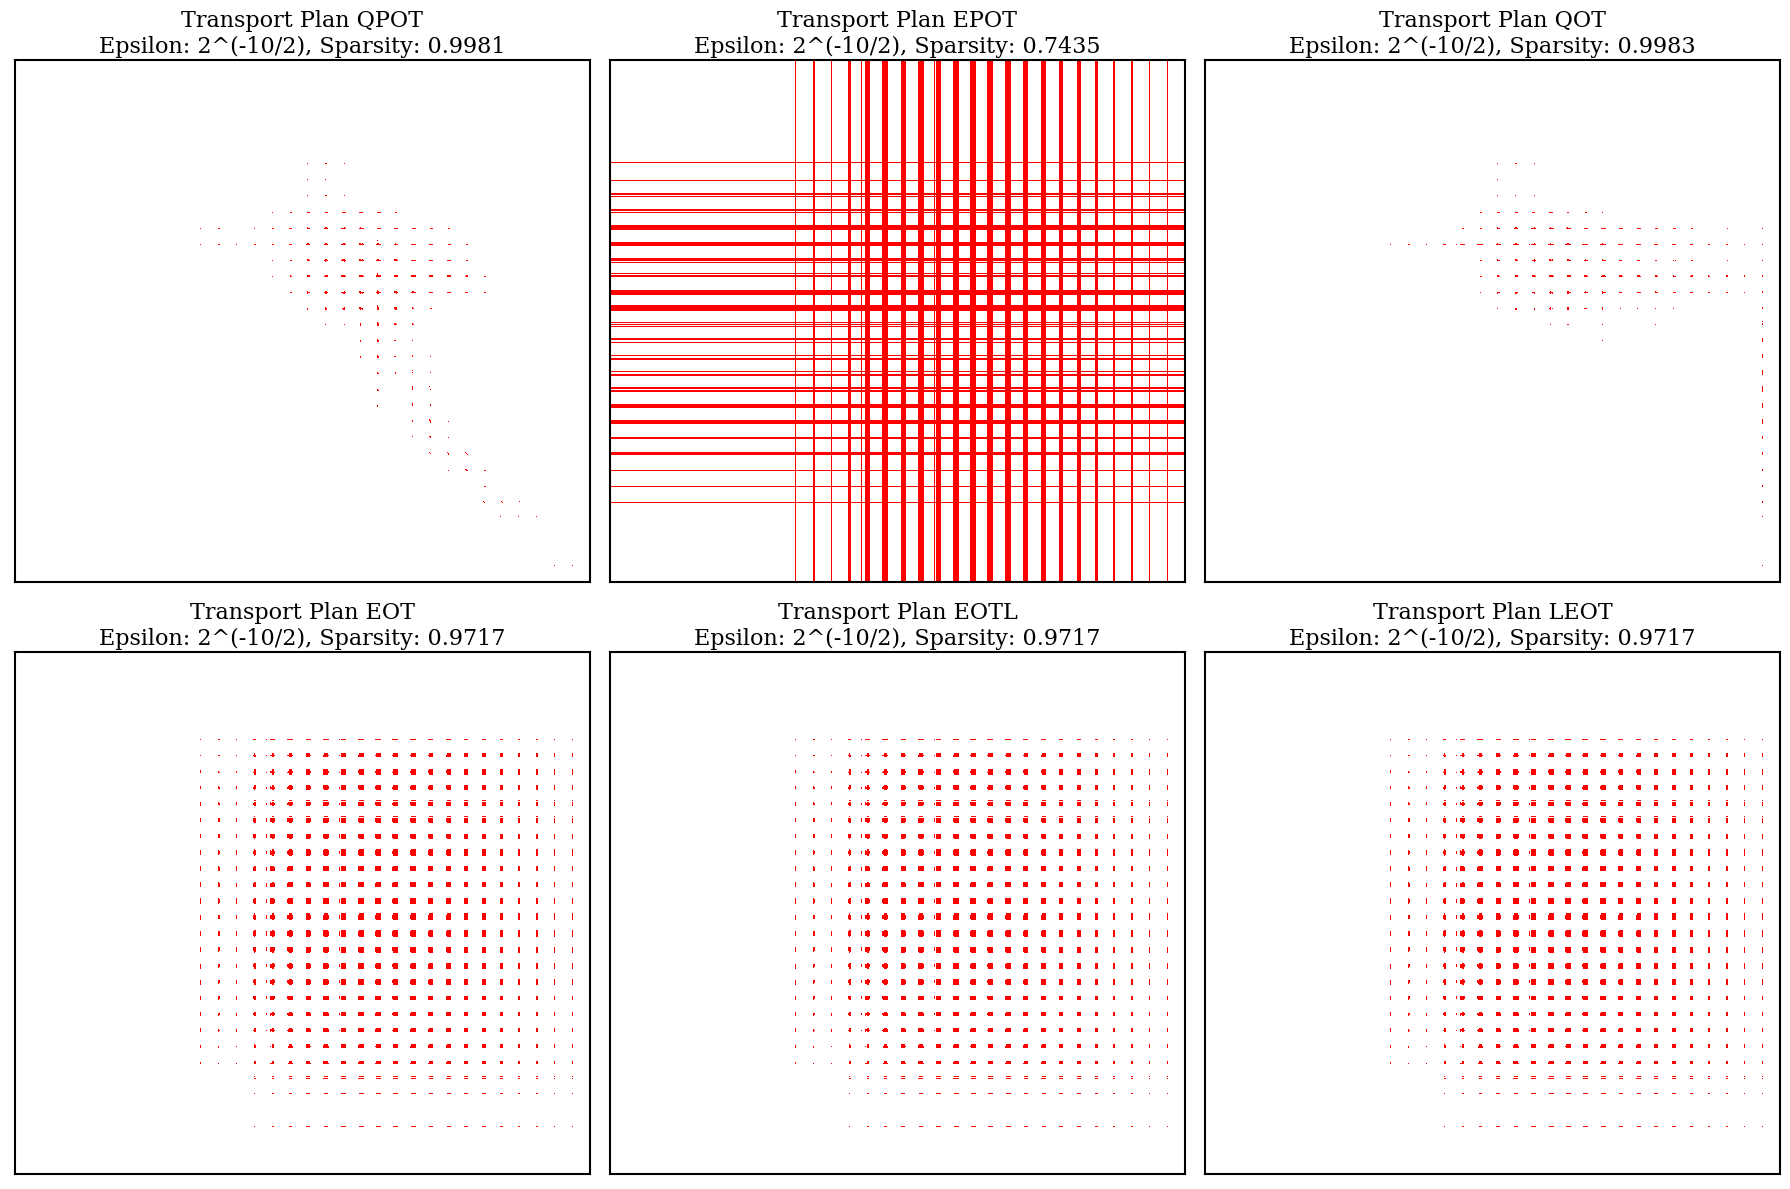

In [12]:
i = 10
epsilon = epsilonsCF[i]
result_dict = {
    "QPOT" : ResultCF_QPOT[i],
    "EPOT" : ResultCF_EPOT[i],
    "QOT" : ResultCF_QOT[i],
    "EOT" : ResultCF_EOT[i],
    "EOTL" : ResultCF_EOTL[i],
    "LEOT" : ResultCF_LEOT[i]
}

round_heatmap(result_dict, epsilon='2^(-'+str(i)+'/2)')

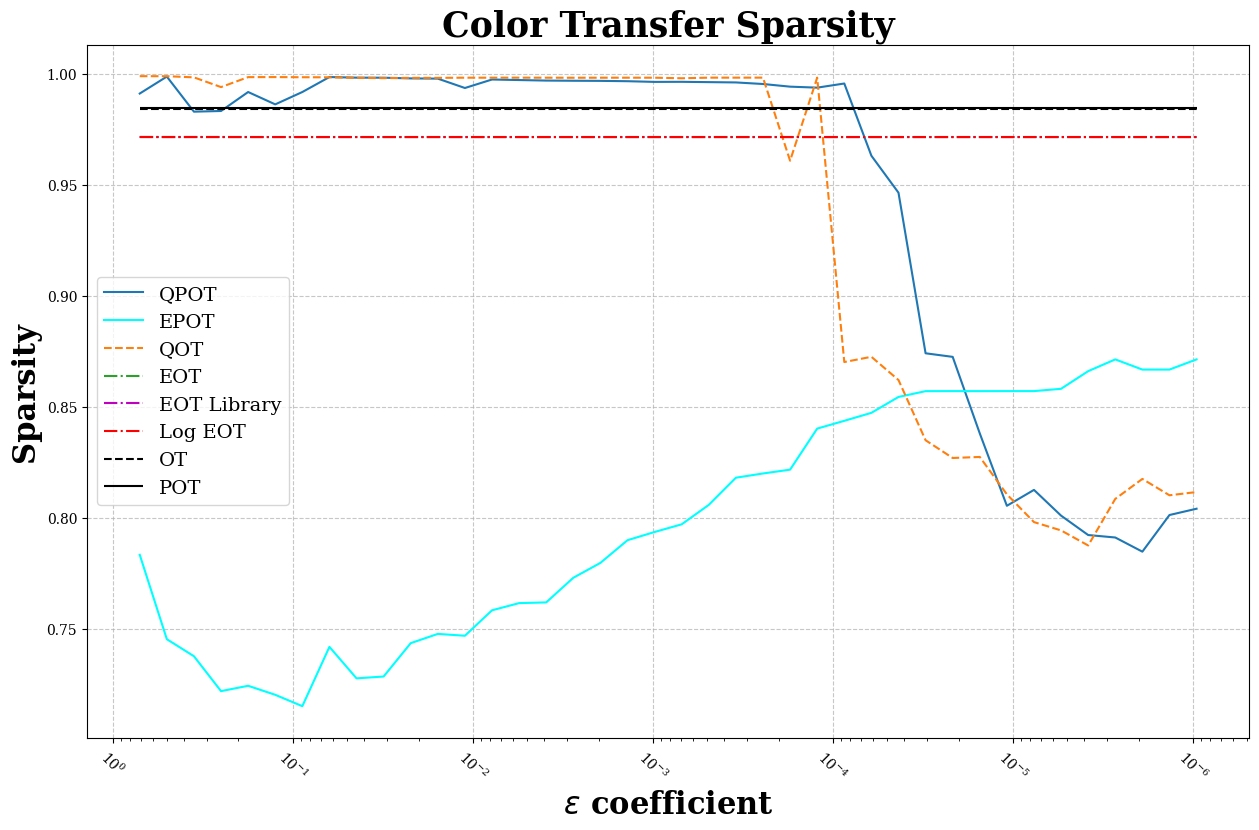

In [15]:
# Sample data
x = np.array([2**(-i/2) for i in range(1,41)])

# Create the plot
plt.figure(figsize=(15, 9))

# Set global font to serif
plt.rcParams['font.family'] = 'serif'

# Plot with improved line styles and colors
plt.plot(x, sparsityCF_QPOT, label="QPOT", color='#1f77b4', linewidth=1.5, linestyle='-')
plt.plot(x, sparsityCF_EPOT, label='EPOT', color='cyan', linewidth=1.5, linestyle='-')
plt.plot(x, sparsityCF_QOT, label='QOT', color='#ff7f0e', linewidth=1.5, linestyle='--')
plt.plot(x, sparsityCF_EOT, label='EOT', color='#2ca02c', linewidth=1.5, linestyle='-.')
plt.plot(x, sparsityCF_EOTL, label='EOT Library', color='m', linewidth=1.5, linestyle='-.')
plt.plot(x, sparsityCF_LEOT, label='Log EOT', color='r', linewidth=1.5, linestyle='-.')

# Draw horizontal lines for OT and POT
plt.hlines(y=sparsityCF_OT, xmin=2**(-1/2), xmax=2**(-40/2), color='k', linewidth=1.5, linestyle='--', label='OT')
plt.hlines(y=sparsityCF_POT, xmin=2**(-1/2), xmax=2**(-40/2), color='k', linewidth=1.5, linestyle='-', label='POT')

# Set title and labels with improved font settings
plt.title('Color Transfer Sparsity', fontsize=25, fontweight='bold')
plt.xlabel(r'$\varepsilon$ coefficient', fontsize=22, fontdict={'family': 'serif', 'weight': 'bold'})
plt.ylabel('Sparsity', fontsize=22, fontdict={'family': 'serif', 'weight': 'bold'})

# Add a grid with a specific style
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=-45)

# Adjust tick parameters
plt.xscale("log")
plt.legend(fontsize=14)
plt.gca().invert_xaxis() 

# Display the plot
plt.show();

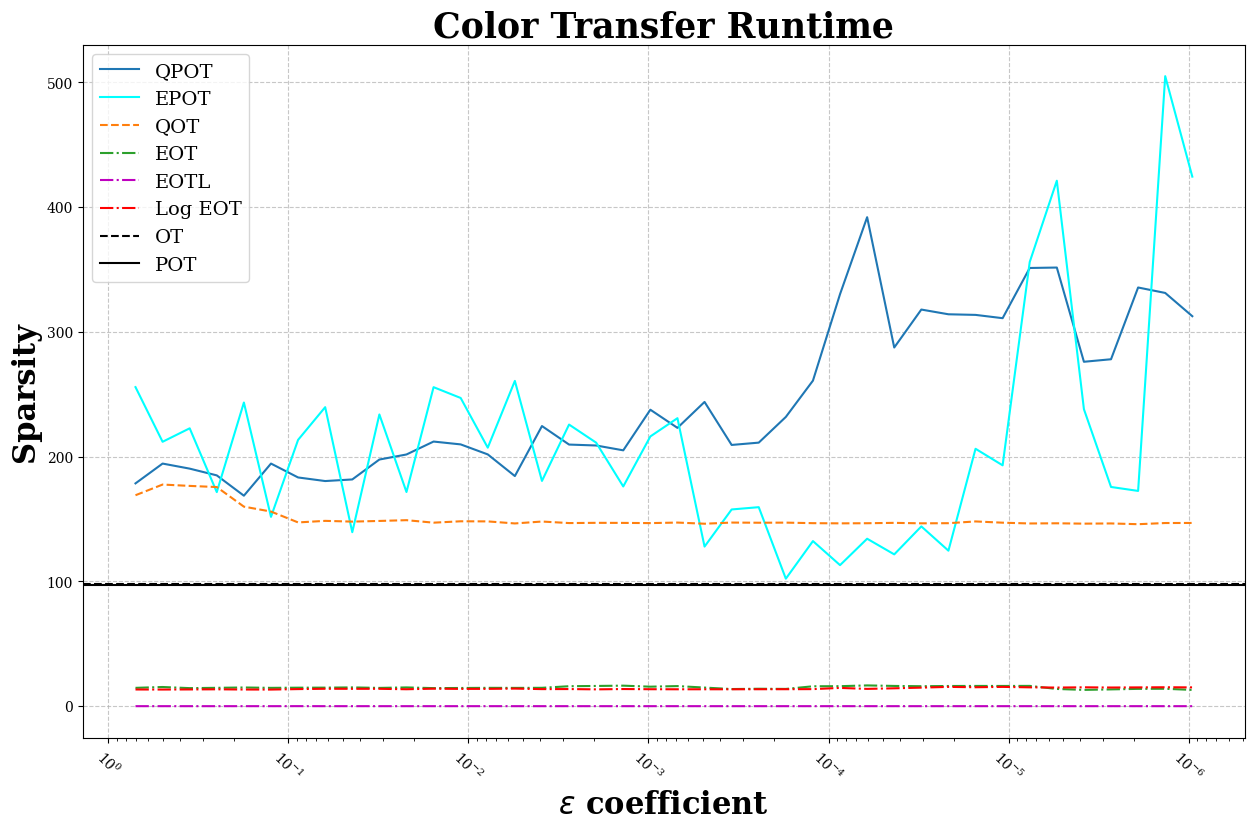

In [57]:
# Sample data
x = np.array([2**(-i/2) for i in range(1,41)])

# Create the plot
plt.figure(figsize=(15, 9))

# Set global font to serif
plt.rcParams['font.family'] = 'serif'

# Plot with improved line styles and colors
plt.plot(x, runtimesCF_QPOT, label="QPOT", color='#1f77b4', linewidth=1.5, linestyle='-')
plt.plot(x, runtimesCF_EPOT, label='EPOT', color='cyan', linewidth=1.5, linestyle='-')
plt.plot(x, runtimesCF_QOT, label='QOT', color='#ff7f0e', linewidth=1.5, linestyle='--')
plt.plot(x, runtimesCF_EOT, label='EOT', color='#2ca02c', linewidth=1.5, linestyle='-.')
plt.plot(x, runtimesCF_EOTL, label='EOTL', color='m', linewidth=1.5, linestyle='-.')
plt.plot(x, runtimesCF_LEOT, label='Log EOT', color='r', linewidth=1.5, linestyle='-.')

# Draw horizontal lines for OT and POT
plt.axhline(y=runtime_OT, color='k', linewidth=1.5, linestyle='--', label='OT')
plt.axhline(y=runtime_POT, color='k', linewidth=1.5, linestyle='-', label='POT')

# Set title and labels with improved font settings
plt.title('Color Transfer Runtime', fontsize=25, fontweight='bold')
plt.xlabel(r'$\varepsilon$ coefficient', fontsize=22, fontdict={'family': 'serif', 'weight': 'bold'})
plt.ylabel('Sparsity', fontsize=22, fontdict={'family': 'serif', 'weight': 'bold'})

# Add a grid with a specific style
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=-45)

# Adjust tick parameters
plt.xscale("log")
plt.legend(fontsize=14)
plt.gca().invert_xaxis() 

# Display the plot
plt.show();